In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import bisect
from IPython.display import clear_output

In [2]:
data_pd = pd.read_excel('eur2017_hours.xls', index_col = [0, 1])
print(data_pd.head())

                       Close
Date       Time             
2017-01-01 22:00:00  64.3460
           23:00:00  64.3580
2017-01-02 00:00:00  64.3610
           01:00:00  64.7335
           02:00:00  64.7369


In [3]:
data = data_pd['Close'].tolist()
length = len(data)

data_neg = [0 for i in range(length)]
for i in range(length):
    data_neg[i] = -data[i]
    
print(data[:5])
print(data_neg[:5])

[64.346, 64.358, 64.361, 64.7335, 64.7369]
[-64.346, -64.358, -64.361, -64.7335, -64.7369]


In [4]:
def find_g_key(n, m):
    #Create arrays for h and all the g's
    h = [0 for x in range(n+1)]
    g = [[0 for x in range(n+1)] for y in range(m+1)]
    g_key = [0 for x in range(m+1)]

    h[n] = 0

    for k in range(1, m+1):
        g[k][n] = 1

    for t in reversed(range(1, n)):
        g[m][t] = (t-m+1)/(t+1)*g[m][t+1]

        sum_max = 0
        for k in reversed(range(1, m+1)):
            sum_max = sum_max + max(h[t+1], g[k][t+1])

            if k<m:
                g[k][t] = k/(t+1)*g[k+1][t+1] + (t-k+1)/(t+1)*g[k][t+1]

        h[t] = 1/(t+1)*sum_max + (t+1-m)/(t+1)*h[t+1]

        for k in range(1, m+1):
            if g[k][t] < h[t]:
                if g_key[k] == 0:
                    g_key[k] = t
    return g_key

In [5]:
results = pd.DataFrame(columns = ('bought', 'day_of_min', 'X_lowest', 'sold', 'day_of_max', 'X_highest', 'return', 'margin_potential'))

In [6]:
g_key = find_g_key(100, 10)
g_key

[0, 31, 43, 52, 60, 67, 73, 78, 83, 88, 93]

In [7]:
signals = pd.read_excel('eur2017_hours.xls')
signals['positions'] = 0.0
print(signals.head())

        Date      Time    Close  positions
0 2017-01-01  22:00:00  64.3460        0.0
1 2017-01-01  23:00:00  64.3580        0.0
2 2017-01-02  00:00:00  64.3610        0.0
3 2017-01-02  01:00:00  64.7335        0.0
4 2017-01-02  02:00:00  64.7369        0.0


In [8]:
n = 100
m = 10

min_success_counter = 0
max_success_counter = 0

for j in range(length-n+1):
    a = []
    a_neg = []
    chosen_min = 0
    chosen_max = 0

    ser = []

    for i in range(j, j+n):         
        new_value = data[i]

        ser.append(new_value)

        position = bisect.bisect_left(a, new_value) + 1
        bisect.insort_left(a, new_value)

        number_parsed = len(a)

        for k in range(1, m+1):
            if number_parsed > g_key[k] and position <= k and chosen_min == 0:
                chosen_min = new_value
                signals['positions'].iloc[i] += 1
                chosen_min_i = i+1-j

        new_value = data_neg[i]

        position = bisect.bisect_left(a_neg, new_value) + 1
        bisect.insort_left(a_neg, new_value)

        number_parsed = len(a_neg)

        for k in range(1, m+1):
            if number_parsed > g_key[k] and position <= k and chosen_max == 0:
                chosen_max = -new_value
                signals['positions'].iloc[i] -= 1
                chosen_max_i = i+1-j

    if chosen_max == 0:
        chosen_max = -new_value
        chosen_max_i = n

    if chosen_min == 0:
        chosen_min = -new_value
        chosen_min_i = n

    real_max = max(a)
    real_min = min(a)
    real_gap = real_max - real_min
    my_margin = chosen_max - chosen_min
    my_return = my_margin/(sum(a)/len(a))
    margin_potential = my_margin/real_gap*100

    chosen_min_pos = a.index(chosen_min)+1 
    chosen_max_pos = a_neg.index(-chosen_max)+1

    results.loc[j] = [chosen_min, chosen_min_i, chosen_min_pos, chosen_max, chosen_max_i, chosen_max_pos, my_return, margin_potential]

    if results['X_lowest'].iloc[j] <= m:
        min_success_counter += 1
    if results['X_highest'].iloc[j] <= m:
        max_success_counter += 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
print(results.tail())

      bought  day_of_min  X_lowest    sold  day_of_max  X_highest    return  \
6328  68.188        39.0       1.0  69.010        90.0       19.0  0.011965   
6329  68.188        38.0       1.0  69.010        89.0       20.0  0.011964   
6330  68.188        37.0       1.0  69.113        89.0       18.0  0.013463   
6331  68.188        36.0       1.0  69.113        88.0       19.0  0.013462   
6332  68.188        35.0       1.0  69.113        87.0       20.0  0.013461   

      margin_potential  
6328         67.211774  
6329         67.211774  
6330         75.633688  
6331         75.633688  
6332         75.633688  


In [10]:
print(signals.head())

        Date      Time    Close  positions
0 2017-01-01  22:00:00  64.3460        0.0
1 2017-01-01  23:00:00  64.3580        0.0
2 2017-01-02  00:00:00  64.3610        0.0
3 2017-01-02  01:00:00  64.7335        0.0
4 2017-01-02  02:00:00  64.7369        0.0


In [11]:
signals = signals.set_index(['Date', 'Time'])

In [12]:
for i in range(len(signals)):
    if signals['positions'].iloc[i]<-10:
        signals['positions'].iloc[i] = -1        
        
    elif signals['positions'].iloc[i]>10:
        signals['positions'].iloc[i] = 1
        
    else:
        signals['positions'].iloc[i] = 0
        
signals['positions'].value_counts()

 0.0    6146
-1.0     145
 1.0     141
Name: positions, dtype: int64

In [13]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `portfolio`
portfolio = pd.DataFrame(index=signals.index).fillna(0.0)

portfolio['eur'] = signals['Close']
portfolio['positions'] = signals['positions']

portfolio['holdings'] = [0 for x in range(len(portfolio))]
portfolio['cash'] = [0 for x in range(len(portfolio))]

portfolio['cash'].iloc[0] = initial_capital

#Buy or sell when the positions are generated
for i in range(len(portfolio)):
    if i!=0:
        portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1]
        portfolio['holdings'].iloc[i] = portfolio['holdings'].iloc[i-1]
    
    cash = portfolio['cash'].iloc[i]
    eur = portfolio['eur'].iloc[i]
    positions = portfolio['positions'].iloc[i]
    holdings = portfolio['holdings'].iloc[i]
    
    if positions == 1:
        holdings += cash/eur
        cash = 0
    if positions == -1:
        cash += holdings*eur
        holdings = 0
        
    portfolio['cash'].iloc[i] = cash
    portfolio['holdings'].iloc[i] = holdings
    
# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']*portfolio['eur']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total']/initial_capital-1
portfolio.drop(['eur'], axis=1)
# Print the first lines of `portfolio`
print(portfolio.tail())

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                         eur  positions  holdings          cash         total  \
Date       Time                                                                 
2017-12-29 23:00:00  69.1950        0.0       0.0  11520.444852  11520.444852   
2017-12-30 00:00:00  69.2920        0.0       0.0  11520.444852  11520.444852   
           01:00:00  69.1582        0.0       0.0  11520.444852  11520.444852   
           02:00:00  69.1890        0.0       0.0  11520.444852  11520.444852   
2017-12-31 22:00:00  69.2100        0.0       0.0  11520.444852  11520.444852   

                      returns  
Date       Time                
2017-12-29 23:00:00  0.152044  
2017-12-30 00:00:00  0.152044  
           01:00:00  0.152044  
           02:00:00  0.152044  
2017-12-31 22:00:00  0.152044  


In [14]:
portfolio.to_excel('portfolio.xlsx')

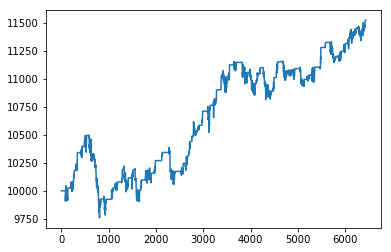

In [15]:
a=[]
for i in range(len(portfolio)-3):
    a.append(portfolio['total'].iloc[i])
plt.plot(a)
plt.show()